In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split

csv_path = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\raw\Bainem\dataset_bainem.csv"
images_folder = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\raw\Bainem\images_bainem"
output_dir =r'C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\Processed'
data_dir = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\Processed"
model_path = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\Notebooks_02\final efficientnet\FINAL\best_model.h5"
OUTPUT_DIR = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\Notebooks_02\final efficientnet\FINAL\outputs"
LOGS_DIR = r"C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\Notebooks_02\final efficientnet\FINAL\logs"
for directory in [OUTPUT_DIR, LOGS_DIR]:
    os.makedirs(directory, exist_ok=True)

In [27]:

# Load the CSV
df = pd.read_csv(csv_path)

# Extract columns
image_ids = df["id"].astype(str)  # Convert to string
boneages = df["boneage"].values   # Bone age labels
sexes = df["male"].values         # Sex labels (0 = Female, 1 = Male)

# Detect hand orientation
def detect_hand_orientation(image):
    """Corrects hand orientation to point upwards."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 30, 100)  # Edge detection
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=15)

    if lines is None:
        return image  # No adjustment needed

    angles = [np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi for x1, y1, x2, y2 in lines[:, 0]]
    median_angle = np.median(angles)

    # Normalize the angle
    if median_angle < -60:
        median_angle += 90
    elif median_angle > 60:
        median_angle -= 90

    # Rotation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT)

    return rotated

# Crop hand region
def crop_hand_region(image):
    """Removes background and crops the hand."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # No cropping needed

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return image[y:y+h, x:x+w]

# Resize image with padding
def resize_image(image, target_size=(224, 224)):
    """Resize the image while maintaining the aspect ratio."""
    h, w = image.shape[:2]

    # Check for valid dimensions
    if h == 0 or w == 0:
        print(f"Error: Invalid image dimensions (h={h}, w={w}).")
        return None

    # Scale factor to maintain aspect ratio
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))

    # Resize the image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Add padding to reach target size
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded

# Preprocess a single image
def preprocess_image(image_path):
    """Pipeline complet de prétraitement."""
    # Chargement en RGB
    image = cv2.imread(img_path)
    if image is None:
       print(f"Fichier non trouvé ou corrompu : {img_path}")
       return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Étapes critiques
    image = detect_hand_orientation(image)
    image = crop_hand_region(image)
    image = resize_image(image)             # Resize with padding

    return image

# Processing du dataset
X_data, y_age, y_sex = [], [], []

with tqdm(total=len(image_ids), desc="Prétraitement") as pbar:
    for img_id, age, sex in zip(image_ids, boneages, sexes):
        img_path = os.path.join(images_folder, f"{img_id}.png")
        processed_img = preprocess_image(img_path)
        
        if processed_img is not None:
            X_data.append(processed_img)
            y_age.append(age)
            y_sex.append(sex)
        pbar.update(1)  # Mise à jour explicite

print(f"\nDonnées sauvegardées : {len(X_data)} images traitées !")

# Conversion et sauvegarde
X_data = np.array(X_data).astype(np.uint8)
y_age = np.array(y_age)
y_sex = np.array(y_sex)

output_dir =r'C:\Users\chahi\Desktop\Age_bone_predection (2)\Age_bone_predection\dataset\Processed'
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "imagesB.npy"), X_data)
np.save(os.path.join(output_dir, "agesB.npy"), y_age)
np.save(os.path.join(output_dir, "sexesB.npy"), y_sex)

print(" Données sauvegardées dans le répertoire npy_files !")


Prétraitement: 100%|██████████| 169/169 [00:17<00:00,  9.59it/s]


Données sauvegardées : 169 images traitées !
 Données sauvegardées dans le répertoire npy_files !


In [28]:

def prepare_datasets(data_dir, batch_size=32, val_split=0.2, augment=True):
    # Chargement des données
    images = np.load(os.path.join(data_dir, "imagesB.npy"))
    ages = np.load(os.path.join(data_dir, "agesB.npy"))
    sexes = np.load(os.path.join(data_dir, "sexesB.npy"))
    
    # Normalisation EfficientNet
    images = preprocess_input(images.astype(np.float32))
    
    # Normalisation de l'âge
    age_mean = np.mean(ages)
    age_std = np.std(ages)
    ages = (ages - age_mean) / age_std
    
    # Création du dataset avec structure ((image, sex), age)
    dataset = tf.data.Dataset.from_tensor_slices(((images, sexes), ages))
    
    # Shuffle avant le split
    dataset = dataset.shuffle(1000, seed=42)
    
    # Calcul de la taille de validation
    val_size = int(len(images) * val_split)
    train_size = len(images) - val_size
    
    # Split du dataset
    train_ds = dataset.skip(val_size)
    val_ds = dataset.take(val_size)
    
    # Définition de l'augmentation
    def augment_data(image, sex, age):
        # Augmentations d'image uniquement
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return (image, sex), age
    
    # Application de l'augmentation seulement au train set
    if augment:
        train_ds = train_ds.map(
            lambda x, y: augment_data(x[0], x[1], y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Batch et optimisation des performances
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, age_mean, age_std




In [ ]:
# 4. Fine-Tuning
# Préparation des datasets pour le fine-tuning
train_ds, val_ds, age_mean, age_std = prepare_datasets( data_dir, batch_size=32, augment=True )

# Charger le meilleur modèle sauvegardé sans compilation automatique
model = tf.keras.models.load_model(
    model_path,
    compile=False  # Important : on va recompiler manuellement
)

# 1. Geler toutes les couches sauf les 20 dernières
for i, layer in enumerate(model.layers):
    if i < len(model.layers) - 50:
        layer.trainable = False
    else:
        layer.trainable = True



# Recompiler avec un learning rate très bas
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='mse',                          
    metrics=['mae']                      
)


# Réentraînement léger
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, min_lr=1e-2, verbose=1),
        #ModelCheckpoint(filepath='fine_tuned_effb0_model.h5', save_best_only=True, monitor='val_mae', mode='min', verbose=1),
        EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True, verbose=1)
    ]

)

# Sauvegarder le modèle final au format .keras (recommandé)
model.save('fine_tuned_effb0_final.keras')

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.1781 - mae: 0.3116 - val_loss: 0.0965 - val_mae: 0.2540 - learning_rate: 1.0000e-04
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step - loss: 0.1850 - mae: 0.3228 - val_loss: 0.0388 - val_mae: 0.1515 - learning_rate: 1.0000e-04
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step - loss: 0.1798 - mae: 0.3375 - val_loss: 0.1677 - val_mae: 0.3230 - learning_rate: 1.0000e-04
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 725ms/step - loss: 0.1866 - mae: 0.3460 - val_loss: 0.0888 - val_mae: 0.2315 - learning_rate: 1.0000e-04
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step - loss: 0.1672 - mae: 0.3143 - val_loss: 0.1019 - val_mae: 0.2639 - learning_rate: 1.0000e-04
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step - loss: 0.1724 - mae: 0.3346 - val_loss: 0.0648 - val_mae: 0.2134 - learning_rate: 1.0000e-04
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - loss: 0.1601 - mae: 0.3172 - val_loss: 0.0585 - val_mae: 0.1985 - learning_rate: 1.000

MAE: 14.87 mois
MSE: 18.85 mois
R²: 0.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


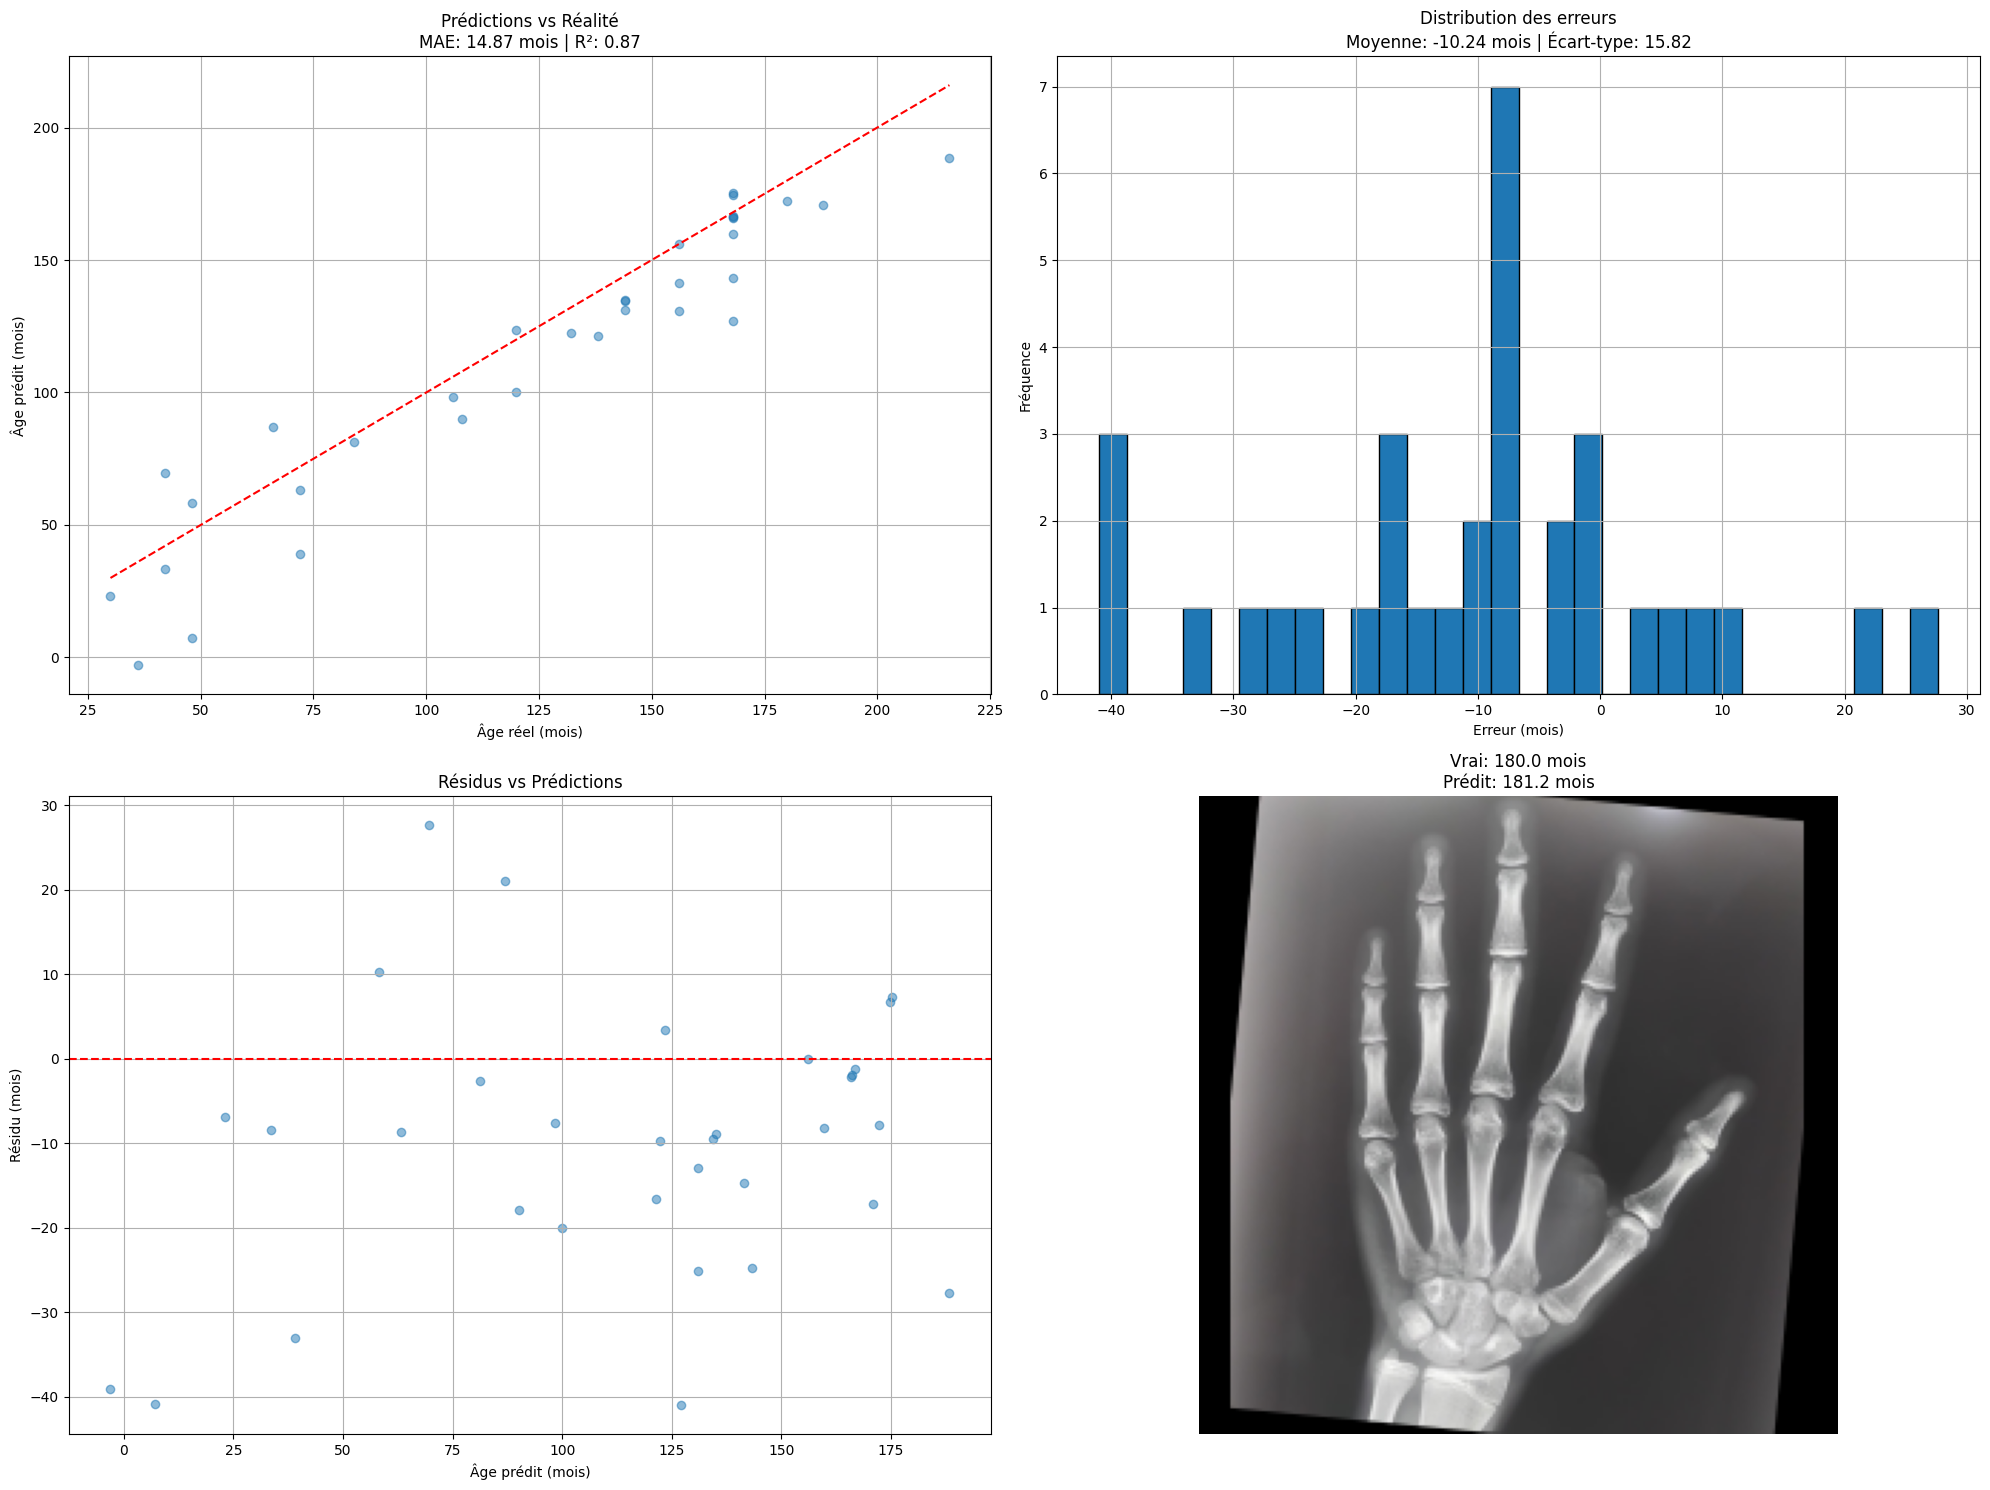

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, dataset, age_mean, age_std):
    # Prédictions
    y_true = []
    y_pred = []
    
    for (images, sexes), ages in dataset:
        preds = model.predict([images, sexes], verbose=0)
        y_true.extend(ages.numpy())
        y_pred.extend(np.atleast_1d(preds.squeeze()))
    
    # Dénormalisation
    y_true = np.array(y_true) * age_std + age_mean
    y_pred = np.array(y_pred) * age_std + age_mean
    
    # Calcul des métriques
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"MAE: {mae:.2f} mois")
    print(f"MSE: {rmse:.2f} mois")
    print(f"R²: {r2:.2f}")

    # Visualisations
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Prédictions vs Réalité
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Âge réel (mois)')
    plt.ylabel('Âge prédit (mois)')
    plt.title(f'Prédictions vs Réalité\nMAE: {mae:.2f} mois | R²: {r2:.2f}')
    plt.grid(True)

    # Plot 2: Distribution des erreurs
    plt.subplot(2, 2, 2)
    errors = y_pred - y_true
    plt.hist(errors, bins=30, edgecolor='black')
    plt.xlabel('Erreur (mois)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des erreurs\nMoyenne: {errors.mean():.2f} mois | Écart-type: {errors.std():.2f}')
    plt.grid(True)

    # Plot 3: Résidus vs Prédictions
    plt.subplot(2, 2, 3)
    plt.scatter(y_pred, errors, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Âge prédit (mois)')
    plt.ylabel('Résidu (mois)')
    plt.title('Résidus vs Prédictions')
    plt.grid(True)

    # Plot 4: Exemples d'images avec prédictions
    plt.subplot(2, 2, 4)
    for i in np.random.choice(len(dataset), 4):  # 4 exemples aléatoires
        (image, sex), true_age = next(iter(dataset.skip(i).take(1)))
        pred_age = model.predict([np.expand_dims(image[0], 0), np.expand_dims(sex[0], 0)])[0][0]
        pred_age = pred_age * age_std + age_mean
        true_age = true_age.numpy()[0] * age_std + age_mean
        
        plt.subplot(2, 2, 4)
        plt.imshow(image[0].numpy().astype(np.uint8))
        plt.title(f"Vrai: {true_age:.1f} mois\nPrédit: {pred_age:.1f} mois")
        plt.axis('off')
        break  # Affiche juste un exemple pour simplifier
    
    plt.tight_layout()
    plt.show()

# Utilisation
model = tf.keras.models.load_model('fine_tuned_effb0_final.keras')  # Charger votre meilleur modèle
_, eval_ds, age_mean, age_std = prepare_datasets(data_dir, augment=False)

evaluate_model(model, eval_ds, age_mean, age_std)



In [64]:
import numpy as np

age_mean = np.mean(y_age)
age_std = np.std(y_age)

print(f"age_mean = {age_mean:.2f}")
print(f"age_std = {age_std:.2f}")


age_mean = 115.18
age_std = 50.08


In [71]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Fonctions de prétraitement (copie celles que tu as déjà) ---

def detect_hand_orientation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=15)

    if lines is None:
        return image

    angles = [np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi for x1, y1, x2, y2 in lines[:, 0]]
    median_angle = np.median(angles)

    if median_angle < -60:
        median_angle += 90
    elif median_angle > 60:
        median_angle -= 90

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT)

    return rotated

def crop_hand_region(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return image[y:y+h, x:x+w]

def resize_image(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    if h == 0 or w == 0:
        print("Erreur : dimensions invalides de l'image.")
        return None
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded

def preprocess_single_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image non trouvée ou corrompue : {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = detect_hand_orientation(image)
    image = crop_hand_region(image)
    image = resize_image(image)
    return image

# --- Fonction principale de prédiction ---

def predict_age_from_image(model_path, age_mean, age_std):
    # Charger le modèle (sans compilation pour éviter les problèmes)
    model = tf.keras.models.load_model(model_path, compile=False)

    # Demander le chemin de l’image
    image_path = input("Entrez le chemin complet de l'image à prédire : ").strip()
    if not os.path.isfile(image_path):
        print("Erreur : fichier image introuvable.")
        return

    # Demander le sexe
    sexe_str = input("Entrez le sexe (0 = féminin, 1 = masculin) : ").strip()
    if sexe_str not in ['0', '1']:
        print("Erreur : sexe doit être 0 ou 1.")
        return
    sexe = int(sexe_str)

    # Prétraitement
    image = preprocess_single_image(image_path)
    if image is None:
        print("Prétraitement impossible, sortie.")
        return

    # Préparation pour le modèle
    img_batch = np.expand_dims(image, axis=0).astype(np.float32)
    img_batch = preprocess_input(img_batch)
    sexe_batch = np.array([[sexe]])

    # Prédiction normalisée
    pred_norm = model.predict((img_batch, sexe_batch))

    # Dé-normalisation de l'âge
    pred_age = pred_norm[0][0] * age_std + age_mean

    print(f"\nÂge osseux estimé pour l'image '{os.path.basename(image_path)}' : {pred_age:.2f} mois")

# --- Exemple d'utilisation ---

if __name__ == "__main__":
    model_path = "bone_age_model_efficientnet.keras"
    print(f"Modèle sans fine tuning :")
    predict_age_from_image(model_path, age_mean, age_std)

    model_path = "fine_tuned_effb0_final.keras"
    print(f"Modèle avec fine tuning :")
    predict_age_from_image(model_path, age_mean, age_std)


Modèle sans fine tuning :
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Âge osseux estimé pour l'image '51.png' : 131.96 mois
Modèle avec fine tuning :
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Âge osseux estimé pour l'image '51.png' : 133.09 mois
